# Лабораторная работа №7.
## Рекуррентные нейронные сети для анализа текста

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text
import gensim.downloader as api
from sklearn.metrics import accuracy_score
import flair
from tqdm import tqdm

BATCH_SIZE = 124
SEED = 41
EPOCH = 10
BUFFER_SIZE = 10000
VECTOR_SIZE = 32

In [2]:
#1. Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.

texts = datasets.load_files("./aclImdb/train", encoding="utf-8")
texts_test = datasets.load_files("./aclImdb/test", encoding="utf-8")
data = pd.DataFrame({'text': texts['data'], 'label': [texts.target_names[i] for i in texts['target']]})
data_test = pd.DataFrame({'text': texts_test['data'], 'label': [texts_test.target_names[i] for i in texts_test['target']]})

data.head()

,text,label
0,Full of (then) unknown actors TSF is a great b...,unsup
1,Amount of disappointment I am getting these da...,unsup
2,"The future, we are told, are what we make of i...",unsup
3,Dan Katzir has produced a wonderful film that ...,pos
4,If you want Scream or anything like the big-st...,pos


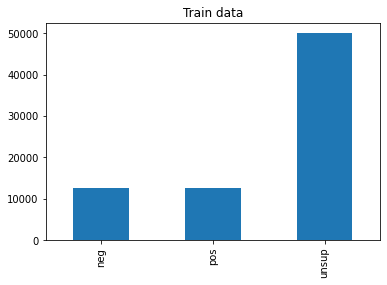

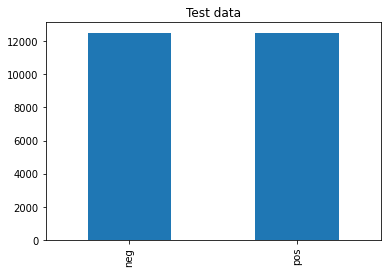

In [4]:
data["label"].value_counts().sort_index().plot.bar()
plt.title("Train data")
plt.show()

data_test["label"].value_counts().sort_index().plot.bar()
plt.title("Test data")
plt.show()

In [5]:
tokenizer = text.Tokenizer(filters='')

vocabulary = pd.read_csv("./aclImdb/imdb.vocab", names=["word"], keep_default_na=False).to_dict()["word"]
tokenizer.fit_on_texts(vocabulary.values())

vocabulary_length = tokenizer.document_count + 1

In [6]:
X_text = data[data['label'] != "unsup"]["text"]
X = sequence.pad_sequences(tokenizer.texts_to_sequences(X_text))
Y = data[data['label'] != "unsup"]["label"].to_numpy()
Y = ((Y == 'pos') * 1)
input_length = X.shape[1]

X_test = sequence.pad_sequences(tokenizer.texts_to_sequences(data_test["text"]), maxlen=input_length)
Y_test = data_test["label"].to_numpy()
Y_test = ((Y_test == 'pos') * 1)

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)

In [8]:
#2. Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?

def get_model():
    model = Sequential()
    model.add(Embedding(vocabulary_length, VECTOR_SIZE, input_length=input_length))
    model.add(Bidirectional(LSTM(64, dropout=0.2)))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    model.summary()
    return model


callbacks = [EarlyStopping(patience=3)]
model = get_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2169, 32)          2864896   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,914,689
Trainable params: 2,914,689
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=callbacks)
print("Loss, Accuracy:", model.evaluate(X_test, Y_test))

Epoch 1/10
162/162 [==============================] - 32s 172ms/step - loss: 0.5380 - accuracy: 0.7052 - val_loss: 0.3743 - val_accuracy: 0.8424

In [24]:
#3. Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?

vec = api.load("word2vec-google-news-300")

tokenized_train = data[data['label'] != "unsup"]["text"].apply(lambda row: text.text_to_word_sequence(row, filters=''))
tokenized_test = data_test["text"].apply(lambda row: text.text_to_word_sequence(row, filters=''))

In [31]:
def to_index(row):
    vectors = []
    for word in row:
        try:
            vectors.append(vec.key_to_index[word] + 1)
        except:
            continue
    return np.array(vectors)

X_vec_train = sequence.pad_sequences(tokenized_train.apply(to_index), maxlen=input_length, dtype=np.float32)
X_vec_train, X_vec_valid, Y_vec_train, Y_vec_valid = train_test_split(X_vec_train, Y, test_size=0.2)

X_vec_test = sequence.pad_sequences(tokenized_test.apply(to_index), maxlen=input_length, dtype=np.float32)

In [32]:
vectors = np.concatenate((np.zeros((1, vec.vectors.shape[1])), vec.vectors), axis=0)

def get_model():
    model = Sequential()
    model.add(Embedding(
        input_dim = vectors.shape[0],
        output_dim = vectors.shape[1],
        input_length = input_length,

        weights = [vectors],
        trainable=False))

    model.add(Bidirectional(GRU(128, dropout=0.2)))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    model.summary()
    return model

callbacks = [EarlyStopping(patience=10)]
model = get_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2169, 300)         900000300 
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 900,330,797
Trainable params: 330,497
Non-trainable params: 900,000,300
_________________________________________________________________


In [33]:
model.fit(X_vec_train, Y_vec_train, validation_data=(X_vec_valid, Y_vec_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=callbacks)
print("Loss, Accuracy:", model.evaluate(X_vec_test, Y_test))

Epoch 1/10
162/162 [==============================] - 56s 312ms/step - loss: 0.5293 - accuracy: 0.7293 - val_loss: 0.4482 - val_accuracy: 0.8122

In [34]:
# 3. Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?


def get_model():
    model = Sequential()
    model.add(Embedding(
        input_dim = vectors.shape[0],
        output_dim = vectors.shape[1],
        input_length = input_length,
        weights = [vectors],
        trainable=False))

    model.add(Conv1D(filters=vectors.shape[1], kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Bidirectional(GRU(64, dropout=0.5)))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    model.summary()
    return model

callbacks = [EarlyStopping(patience=10)]
model = get_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2169, 300)         900000300 
_________________________________________________________________
conv1d (Conv1D)              (None, 2169, 300)         270300    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1084, 300)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1084, 300)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               140544    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 900,411,273
Trainable params: 410,973
Non-trainable params: 900,000,300
__________________________________

In [35]:
model.fit(X_vec_train, Y_vec_train, validation_data=(X_vec_valid, Y_vec_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=callbacks)
print("Loss, Accuracy:", model.evaluate(X_vec_test, Y_test))

Epoch 1/10
162/162 [==============================] - 34s 177ms/step - loss: 0.5335 - accuracy: 0.7205 - val_loss: 0.3843 - val_accuracy: 0.8356

In [61]:
# 4.
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

def predict(text):
    s = flair.data.Sentence(text)
    flair_sentiment.predict(s)
    if "POSITIVE" == s.labels[0].value:
        return  1
    else:
        return 0

2021-05-11 20:36:04,858 loading file C:\Users\User\.flair\models\sentiment-en-mix-distillbert_4.pt


In [76]:
predictions = []

for text in tqdm(data_test.text):
    predictions.append(predict(text))

print("Accuracy on Flair pretrained:", accuracy_score(Y_test, predictions))

100%|██████████| 25000/25000 [1:05:36<00:00,  6.35it/s]

Accuracy on Flair pretrained: 0.90056
